In [ ]:
# Установка необходимых библиотек
%pip install numpy
%pip install torch torchvision
%pip install jupyter
%pip install scikit-learn
%pip install seaborn matplotlib
# !pip install numpy
# !pip install torch torchvision
# !pip install jupyter
# !pip install scikit-learn
# !pip install seaborn matplotlib

## Импорт необходимых библиотек


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Проверка доступа к GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}.")

device


Running on cpu.


device(type='cpu')

## Fashion MNIST


![Fashion MNIST Sample](https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png)

zalandoresearch / github.com

В Fashion MNIST есть следующие классы:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |


## Загрузка и предобработка данных

Для обработки и использования датасета Fashion MNIST с PyTorch мы будем использовать модуль `torchvision`, который предоставляет удобный API для загрузки и преобразования датасетов.

## Утилиты PyTorch
### torchvision

`torchvision`— это библиотека в экосистеме PyTorch, которая предоставляет набор утилит для задач компьютерного зрения. Она включает:

- предобученные модели (такие как ResNet, VGG и AlexNet);
- популярные датасеты и преобразования для их предобработки;
- утилиты для создания собственных датасетов и загрузчиков данных.

На этом занятии мы будем использовать `torchvision` для доступа к датасету Fashion MNIST и для применения преобразований к изображениям.

### torch.utils

`torch.utils` — это утилитарный модуль в PyTorch, предоставляющий несколько подмодулей для выполнения различных задач. Одним из часто используемых подмодулей является `data`, который помогает работать с датасетами и предоставляет инструменты для их эффективной загрузки и предобработки.

### DataLoader

`DataLoader` — это класс в `torch.utils.data`, который оборачивает датасет и предоставляет мини-пакеты (mini-batches) данных. Он предлагает:

- Формирование пакетов данных: вместо обучения на всём датасете сразу чаще используется обучение на небольших пакетах данных для лучшей оптимизации и более быстрого обучения.
- Перемешивание: случайная перестановка тренировочных данных в начале каждой эпохи для уменьшения дисперсии модели.
- Параллельная загрузка: использование многопоточности для подготовки пакетов в фоновом режиме, что обеспечивает максимальную загрузку GPU/CPU.
В контексте этого занятия DataLoader используется для загрузки датасета Fashion MNIST по пакетам, их перемешивания и обеспечения эффективной загрузки с помощью нескольких рабочих потоков.

Теперь давайте подробно разберём предоставленный код и рассмотрим его построчно.



In [ ]:
# Импорт трансформеров
import torchvision.transforms as transforms

# Этот код создаёт пайплайн преобразований. Здесь используется только преобразование ToTensor(), которое конвертирует изображения в формат тензоров PyTorch.
# Это позволяет использовать их в нейронных сетях.
transform = transforms.Compose([transforms.ToTensor()])

# Загрузка тренировочного датасета Fashion MNIST
# root='./data': указывает директорию, куда будет сохранён датасет.
# train=True: загружает тренировочную часть датасета.
# download=True: загружает датасет, если он ещё не существует в указанной директории.
# transform=transform: применяет указанные преобразования к изображениям.
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Создание загрузчика данных для тренировочного набора
# trainset: используется тренировочный набор данных, загруженный ранее.
# batch_size=4: размер одного пакета данных равен 4.
# shuffle=True: перемешивает данные в начале каждой эпохи для уменьшения зависимости от порядка данных.
# num_workers=2: указывает, что два процесса будут использоваться для загрузки данных.
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

# Загрузка тестового датасета Fashion MNIST.
# train=False: загружается тестовая часть датасета.
# shuffle=False: данные не перемешиваются, чтобы сохранить порядок тестовых данных.
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

# Определение классов для Fashion MNIST
# Этот список определяет названия классов для элементов датасета. Они соответствуют меткам, которые будут предсказываться моделью.
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

100.0%


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



## Создание базовой свёрточной нейронной сети (CNN) для датасета
Свёрточные нейронные сети (Convolutional Neural Networks, CNNs) действительно произвели революцию в области компьютерного зрения. Благодаря своей архитектуре они способны эффективно распознавать визуальные шаблоны непосредственно из изображений. Рассмотрим основные компоненты CNN и реализуем её для работы с датасетом Fashion MNIST.

![CNN Architecture](https://miro.medium.com/max/2824/1*uAeANQIOQPqWZnnuH-VEyw.jpeg)
Дмитрий ПереводIT / medium.com (недоступен при авторизации с территории Российской Федерации)

### Основные слои в CNN
1. **Слои свёртки (Convolutional Layers).** Выполняют свёртку над входными данными с фильтрами для выявления признаков (например, краёв, текстур).
2. **Слои активации (Activation Layers).** Добавляют нелинейность в модель. Обычно используется функция активации ReLU (Rectified Linear Unit).
3. **Слои подвыборки (Pooling Layers).** Снижают размерность данных, сохраняя важные признаки. Наиболее распространённый тип — Max Pooling.
4. **Полносвязные слои (Fully Connected Layers).** После слоёв свёртки и подвыборки высокоуровневые признаки объединяются и используются для предсказания классов.


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        # Вход: [batch_size, 1, 28, 28]
        self.conv1 = nn.Conv2d(1, 32, 3)  # Выход: [batch_size, 32, 26, 26]

        # Вход: [batch_size, 32, 26, 26]
        self.conv2 = nn.Conv2d(32, 64, 3) # Выход: [batch_size, 64, 11, 11]

        self.fc1 = nn.Linear(64 * 5 * 5, 128)  # Вытягивание: [batch_size, 64*5*5]
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Вход: [batch_size, 1, 28, 28]
        x = F.relu(self.conv1(x))
        # Форма: [batch_size, 32, 26, 26]
        x = F.max_pool2d(x, 2)
        # Форма: [batch_size, 32, 13, 13]

        x = F.relu(self.conv2(x))
        # Форма: [batch_size, 64, 11, 11]
        x = F.max_pool2d(x, 2)
        # Форма: [batch_size, 64, 5, 5]

        x = x.view(-1, 64 * 5 * 5) # Вытягивание
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## Обучение и оценка модели

### 1. Создание экземпляра модели
Перед началом обучения мы создаём экземпляр нашей модели и определяем устройство для вычислений (CPU или GPU).

In [ ]:
model = BasicCNN().to(device)


### 2. Оптимизатор и функция потерь

Для обучения нейронной сети нам необходимы оптимизатор и функция потерь. Оптимизатор обновляет параметры модели (веса и смещения) для минимизации функции потерь.

- **Оптимизатор.** Часто используется оптимизатор Adam, который адаптирует скорость обучения в процессе тренировки.
- **Функция потерь.** Поскольку это задача классификации, мы используем Cross Entropy Loss.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

## Понимание оптимизаторов и функций потерь

### Оптимизаторы

Оптимизаторы — это алгоритмы, используемые для корректировки весов модели на основе градиента функции потерь. Цель состоит в минимизации потерь. Существует несколько видов оптимизаторов:

1. **SGD (Stochastic Gradient Descent).** Базовая форма алгоритма градиентного спуска. Обновляет веса модели, используя градиент функции потерь по каждому весу.
    - Использование: `torch.optim.SGD(model.parameters(), lr=learning_rate)`.

2. **Momentum.** Вариант SGD, который учитывает предыдущие шаги, помогая ускорить сходимость и избежать локальных минимумов.
    - Использование: `torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)`.

3. **Adam.** Сочетает преимущества двух других расширений SGD: AdaGrad и RMSProp. Адаптирует скорость обучения каждого веса на основе исторической информации о градиентах.
    - Использование: `torch.optim.Adam(model.parameters(), lr=learning_rate)`.

4. **RMSProp.** Поддерживает скользящее среднее квадрата градиентов и делит градиент на корень из этого среднего.
    - Использование: `torch.optim.RMSprop(model.parameters(), lr=learning_rate)`.

### Loss Functions for Classification

1. **Cross-Entropy Loss.** Используется для многоклассовой классификации. Оценивает разницу между предсказанным распределением вероятностей и фактическим распределением.
    - Использование: `nn.CrossEntropyLoss()`.

2. **Binary Cross-Entropy Loss.** Предназначена для задач бинарной классификации.
    - Использование: `nn.BCELoss()`.

3. **Hinge Loss (or Margin Loss).** Используется для классификации с «максимальным отступом», чаще всего для SVM.
    - Использование: `nn.HingeEmbeddingLoss()`.

### Identifying the Task

- **Classification.** Цель — предсказать метку класса для входных данных. Например, если датасет содержит категории (например, «кот», «собака», «рубашка», «сандалии»), это задача классификации.

- **Segmentation.** Цель — классифицировать каждый пиксель изображения. Например, если датасет содержит изображения с цветными регионами, обозначающими разные объекты или характеристики, это задача сегментации.

- **Regression.** Цель — предсказать непрерывное значение. Например, если датасет содержит числовые значения (например, цены на дома, цены акций) в качестве меток, это задача регрессии.

Для определения типа задачи необходимо изучить метки в датасете и требования задачи:

- Если нужно предсказать категорию объекта, это классификация.
- Если требуется предсказать числовое значение, это регрессия.
- Если задача связана с классификацией каждого пикселя, это сегментация.


## 3. Объяснение тренировочного цикла нейронной сети
Обучение нейронной сети включает итеративное обновление её весов для минимизации функции потерь. Это достигается с использованием алгоритмов оптимизации, основанных на градиентном спуске. Вот подробное объяснение этапов тренировочного цикла:

1. **Epochs.** Эпоха — это один полный проход по всему тренировочному набору данных, включающий прямой и обратный проход.  Количество эпох (`num_epochs`) задаётся вручную и определяет, сколько раз алгоритм обучения пройдёт по всему датасету.

2. **Model Training Mode.** Нейронные сети могут работать в двух режимах: обучении и оценке. Некоторые слои (например, Dropout или Batch Normalization) ведут себя по-разному в этих режимах. Установка режима обучения (model.train()) гарантирует правильную работу слоёв, таких как Dropout.

3. **Batch Processing.** Обновление весов после каждого примера (стохастический градиентный спуск) слишком нестабильно. Обновление после всего датасета (градиентный спуск на всём батче) слишком медленно. Использование мини-батчей — это баланс между скоростью и стабильностью.

4. **Zeroing Gradients.** В PyTorch градиенты накапливаются после каждого шага обратного распространения. Перед вычислением новых градиентов для текущего батча необходимо обнулить старые.

5. **Forward Pass.** Данные (например, изображения) передаются через сеть слой за слоем до получения выходных значений. Этот процесс называется прямым проходом, или `forward pass`.

6. **Calculate Loss.** Результаты сети (выходы) сравниваются с истинными метками с помощью функции потерь. Потери показывают, насколько хорошо предсказания сети совпадают с правильными метками.

7. **Backward Pass.** Для обновления весов необходимо вычислить градиенты функции потерь по каждому параметру. Обратный проход (`backpropagation`) вычисляет эти градиенты, распространяя ошибку от выходного слоя к входному.

8. **Update Weights.** Оптимизатор обновляет веса модели на основе вычисленных градиентов и заданной скорости обучения.

Этот цикл (прямой проход, вычисление потерь, обратный проход, обновление весов) выполняется для каждого батча в тренировочном наборе данных, а затем повторяется для заданного количества эпох.

In [ ]:
# Number of complete passes through the dataset
num_epochs = 5

# Start the training loop
for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()

    # Iterate over each batch of the training data
    for images, labels in trainloader:
        # Move the images and labels to the computational device (CPU or GPU)
        images, labels = images.to(device), labels.to(device)

        # Clear the gradients from the previous iteration
        optimizer.zero_grad()

        # Forward pass: Pass the images through the model to get the predicted outputs
        outputs = model(images)

        # Compute the loss between the predicted outputs and the true labels
        loss = criterion(outputs, labels)

        # Backward pass: Compute the gradient of the loss w.r.t. model parameters
        loss.backward()

        # Update the model parameters
        optimizer.step()


## Оценка

После обучения модели крайне важно оценить её производительность на невидимых данных. Для этого нужно:

1. Сгенерировать предсказания для тестового набора.
2. Вычислить метрику `accuracy`.
3. Изучить производительность модели, используя `confusion matrix` и `classification report`.

Так можно определить, насколько хорошо модель справляется с задачей и требуется ли доработка.

**Заметьте,** нам не нужно вычислять градиенты, поэтому используем `torch.no_grad()`.

              precision    recall  f1-score   support

 T-shirt/top       0.88      0.83      0.85      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.81      0.86      0.83      1000
       Dress       0.89      0.91      0.90      1000
        Coat       0.87      0.76      0.81      1000
      Sandal       0.98      0.97      0.98      1000
       Shirt       0.67      0.76      0.71      1000
     Sneaker       0.93      0.97      0.95      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.97      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



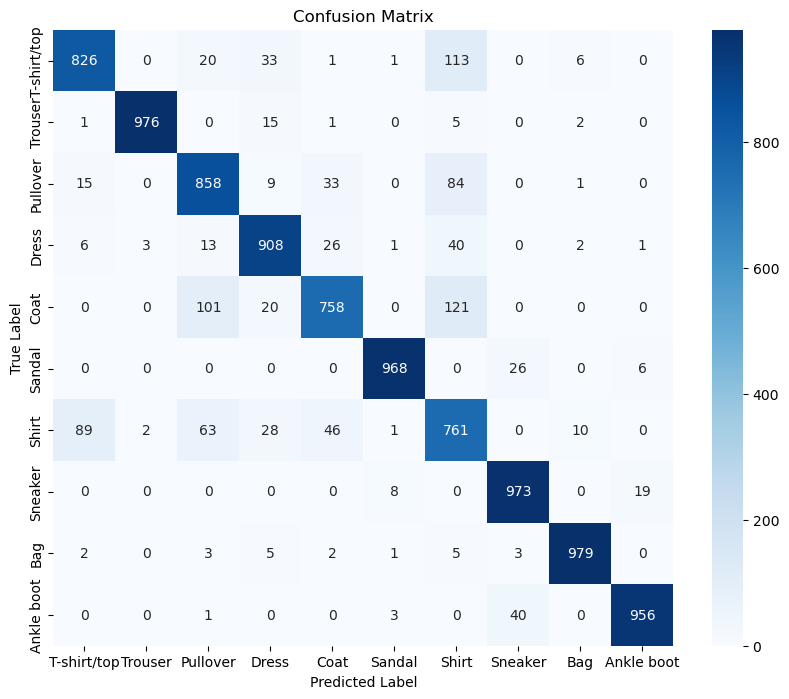

In [ ]:

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Перевод модели в режим оценки
model.eval()

# Пустые массивы для хранения предсказаний и меток
all_preds = []
all_labels = []


with torch.no_grad():
    # Итерируемся по всем батчам в test loader
    for images, labels in testloader:
        # Переводим изображения и метки на вычислительное устройство (CPU или GPU)
        images, labels = images.to(device), labels.to(device)

        # Пропускаем изображение через модель и получаем предсказание
        outputs = model(images)

        # Получаем класс в соответствии с максимальной вероятностью предсказанного класса
        _, predicted = torch.max(outputs, 1)

        # Заполняем массив предсказаниями
        all_preds.extend(predicted.cpu().numpy())

        # Заполняем массив истинными значениями меток классов
        all_labels.extend(labels.cpu().numpy())

# Печатаем отчёт о работе модели для каждого класса
print(classification_report(all_labels, all_preds, target_names=classes))

# Вычисляем confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Строим тепловую карту
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')  # x-axis label
plt.ylabel('True Label')       # y-axis label
plt.title('Confusion Matrix')  # Title of the plot
plt.show()                     # Display the plot


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class NetDropout(nn.Module):
    def __init__(self):
        super(NetDropout, self).__init__()

        # Конволюционные слои
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)  # Выходная форма: [batch_size, 32, 28, 28]
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1) # Выходная форма: [batch_size, 64, 14, 14]

        # Слой Max pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # Уменьшает пространственные размеры вдвое

        # Слой Dropout
        self.dropout = nn.Dropout(0.25)  # Предотвращает переобучение

        # Полносвязные слои
        self.fc1 = nn.Linear(64 * 7 * 7, 512)  # Вытягивание входных данных в 512 фич
        self.fc2 = nn.Linear(512, 10)          # 512 входных фич переходят в 10 классов

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # Форма: [batch_size, 32, 14, 14]
        x = self.pool(F.relu(self.conv2(x))) # Форма: [batch_size, 64, 7, 7]

        x = x.view(-1, 64 * 7 * 7)  # Вытягивание в тензор
        x = self.dropout(x)         #  Применение dropout

        x = F.relu(self.fc1(x))     # Первый полносвязный слой с ReLU-активацией
        x = self.fc2(x)             # Второй полносвязный слой

        # Здесь мы не используем log_softmax. Если использовать nn.CrossEntropyLoss как функцию потерь позже,
        # то она неявно применит softmax.
        # Если вы планируете использовать nn.NLLLoss, расскоментируйте строку ниже:
        # x = F.log_softmax(x, dim=1)

        return x

# Создание экземпляра модели с dropout
model_dropout = NetDropout().to(device)
model_dropout


NetDropout(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

## Дополнение: регуляризация с Dropout

Dropout — это метод регуляризации для уменьшения переобучения в нейронных сетях. Во время обучения случайно выбранные нейроны игнорируются, что помогает предотвратить чрезмерную зависимость модели от какого-либо конкретного нейрона. Этот процесс исключения вносит в процесс обучения своего рода шум, который может привести к лучшему обобщению.

![Dropout](https://miro.medium.com/max/1200/1*iWQzxhVlvadk6VAJjsgXgg.png)
Sketcher / neerc.ifmo.ru

Изменим модель, добавив dropout.


## Понимание роли `F.log_softmax`

Применение функции `F.log_softmax` в конце модели имеет важное значение в определённых контекстах, и важно понимать, зачем и когда мы её используем.

### Softmax
Функция **softmax** часто используется в конечном слое классификационной нейронной сети. Её основная роль — преобразовать необработанные оценки, также известные как логиты, которые сеть выдаёт, в распределение вероятностей для различных классов. Результаты этого преобразования — значения в диапазоне (0, 1), и, что важно, их сумма равна 1.


### Log Softmax
С другой стороны, `Log Softmax` — это применение логарифма после преобразования с помощью softmax. Эта трансформация даёт логарифмические вероятности. В PyTorch часто используется пара: `F.log_softmax` и `nn.NLLLoss` (Negative Log Likelihood Loss), поскольку последняя ожидает в качестве входа логарифмические вероятности.

### Почему стоит выбрать `F.log_softmax`, а не последовательное использование `F.softmax` и затем логарифма?
Основная причина — числовая стабильность. Когда операции объединены в единую функцию `log_softmax`, они выполняются более стабильно, чем при их последовательном применении (сначала softmax, затем логарифм). Это особенно важно для числовой точности в задачах с большими или малыми значениями.

### Что, если не использовать `F.log_softmax`?
Если в модели не применяется `log_softmax` (или даже `softmax`), то её выходные данные остаются необработанными оценками (логитами). Когда используется функция потерь `nn.CrossEntropyLoss`, явное применение `softmax` или `log_softmax` становится ненужным, так как эта функция потерь автоматически обрабатывает их. Напротив, если выбирается функция потерь `nn.NLLLoss`, то применение `log_softmax` становится необходимым. Отказ от использования softmax означает, что предсказания модели не будут интерпретироваться как допустимые вероятности.


In [ ]:
optimizer = torch.optim.Adam(model_dropout.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


## Обучение

## Логирование и наблюдение за потерями во время обучения

Во время обучения нейронных сетей важно отслеживать различные метрики, чтобы понять, как хорошо модель учится. Одной из фундаментальных метрик для отслеживания является потеря (loss). Потери показывают расхождения между предсказаниями модели и истинными метками. Низкие потери обычно означают, что предсказания модели ближе к истинным значениям.

### Важность логирования потерь

1. **Мониторинг сходимости.** Потери должны обычно уменьшаться по мере продвижения обучения. Если потери перестают уменьшаться (или начинают увеличиваться), это может указывать на то, что модель начала переобучаться, или на наличие других проблем, таких как слишком высокая скорость обучения, вызывающая расходимость.

2. **Тюнинг гиперпараметров.** Наблюдение за потерями может помочь в настройке гиперпараметров. Например, если потери уменьшаются очень медленно, повышение скорости обучения или изменение оптимизатора может помочь. С другой стороны, если потери показывают высокую изменчивость, уменьшение скорости обучения может быть полезным.

3. **Сравнение моделей.** При экспериментировании с различными архитектурами или стратегиями потери предоставляют способ сравнения эффективности различных моделей.

4. **Раннее завершение.** Отслеживание потерь на валидационном наборе данных позволяет остановить обучение, когда потери на валидации начинают расти, предотвращая переобучение.

### Best Practices

- **Визуализация.** Хотя вывод потерь в консоль полезен, визуализация их с помощью графиков может быть ещё более информативной. Инструменты, такие как TensorBoard, или библиотеки, такие как Matplotlib, могут быть использованы для построения графиков потерь по эпохам, что даёт более ясное представление о динамике обучения.

- **Частота логирования.** В зависимости от длительности обучения, можно логировать потери каждую эпоху, каждые N батчей или даже после каждого батча. Выбирайте частоту, которая обеспечит хороший баланс между полезной информацией и перегрузкой данными.

- **Дополнительные метрики.** Помимо потерь, часто полезно отслеживать другие метрики, такие как точность, прецизионность, полнота и так далее, особенно на валидационном наборе данных. Эти метрики дают более полное представление о производительности модели.

Постоянный мониторинг и логирование потерь во время обучения — это основная практика в глубоком обучении. Это служит первым диагностическим инструментом для процесса обучения, позволяя своевременно вмешиваться и направлять улучшения.


In [ ]:
num_epochs = 5

# Старт эпохи обучения
for epoch in range(num_epochs):
    # Переменная для контроля совокупных потерь за эпоху
    running_loss = 0.0

    # Перевод модели в режим обучения
    model_dropout.train()


    for i, (images, labels) in enumerate(trainloader):
        # Передача на устройство (CPU или GPU)
        images, labels = images.to(device), labels.to(device)

        # Очистка градиентов
        optimizer.zero_grad()

        # Прямой проход: передача изображения в модель
        outputs = model_dropout(images)

        # Вычисление потерь
        loss = criterion(outputs, labels)

        # Обратный проход: вычисление градиента потерь
        loss.backward()

        # Обновление параметров модели
        optimizer.step()

        # Обновление running loss
        running_loss += loss.item()


    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}")

print("Finished Training")



Epoch [1/5], Loss: 0.3927
Epoch [2/5], Loss: 0.2781
Epoch [3/5], Loss: 0.2470
Epoch [4/5], Loss: 0.2290
Epoch [5/5], Loss: 0.2131
Finished Training


## Оценка

## Повторное использование кода для оценки и важность тестирования на валидационном наборе

В последующих шагах я буду использовать тот же код для оценки, который мы обсуждали ранее. Возможно, у вас возникнут вопросы: «Почему не изменить его?» или «Зачем эта стадия вообще нужна?». Давайте разберёмся, почему это важно.

### Суть оценки

1. **Обобщение.** Хотя модель может показывать отличные результаты на обучающих данных, важно понять, как она будет вести себя на новых, невидимых данных. Оценка на тестовом или валидационном наборе даёт представление о способности модели обобщать информацию на новые примеры, что является основной целью построения моделей машинного обучения.

2. **Обнаружение переобучения.** Если модель показывает отличные результаты на обучающих данных, но плохо справляется с валидационным набором, это может быть признаком переобучения. Переобучение происходит, когда модель слишком хорошо «запоминает» обучающие данные, включая шум и выбросы, что снижает её эффективность на новых данных.

3. **Сравнение моделей.** Метрики оценки на валидационном наборе дают объективную основу для сравнения различных моделей или стратегий, помогая выбрать наилучшую для решения поставленной задачи.

4. **Тюнинг гиперпараметров.** Производительность на валидационном наборе может помочь в настройке гиперпараметров модели. Это предоставляет обратную связь о том, насколько эффективны изменения, и помогает удостовериться, что они действительно приводят к улучшениям, а не просто к лучшей подгонке модели под обучающие данные.

### Почему нужно повторно использовать код для оценки?

- **Согласованность.** Использование одного и того же кода для оценки гарантирует согласованность результатов, делая сравнение моделей действительным и значимым.

- **Эффективность.** Нет необходимости «изобретать колесо», если текущий код для оценки уже эффективно оценивает производительность модели на валидационном наборе.

- **Точность.** Проверенный код для оценки, который уже зарекомендовал себя как корректный, снижает вероятность возникновения ошибок в процессе оценки.



Регулярная оценка модели на валидационном или тестовом наборе данных — это неотъемлемая практика в машинном обучении. Она позволяет понять, как модель будет работать в реальных условиях, за пределами обучающих данных.

**Примечание.** Мы оцениваем модель с dropout, поэтому используем `model_dropout`.

              precision    recall  f1-score   support

 T-shirt/top       0.84      0.87      0.86      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.86      0.86      0.86      1000
       Dress       0.93      0.92      0.92      1000
        Coat       0.84      0.88      0.86      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.75      0.70      0.72      1000
     Sneaker       0.96      0.97      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.97      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



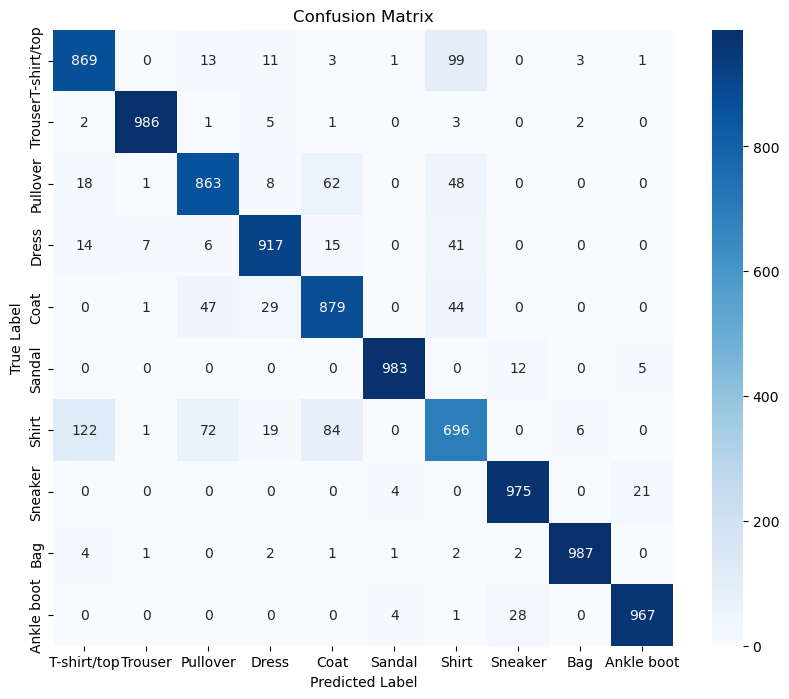

In [ ]:

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


model_dropout.eval()


all_preds = []
all_labels = []


with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_dropout(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
print(classification_report(all_labels, all_preds, target_names=classes))

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')  # x-axis label
plt.ylabel('True Label')       # y-axis label
plt.title('Confusion Matrix')  # Title of the plot
plt.show()                     # Display the plot


## Расширенные темы: аугментация данных

## Понимание аугментации данных

Аугментация данных — это мощная техника, позволяющая искусственно увеличить размер обучающего набора данных. Применяя различные трансформации к исходным изображениям, мы можем смоделировать разнообразие и случайность, которые модель может встретить в реальных сценариях, что улучшает её устойчивость и способность к обобщению.

### Преимущества аугментации данных

1. **Предотвращение переобучения.** Введение случайности в обучающие данные помогает предотвратить запоминание модели конкретных шаблонов, что делает модель более обобщённой.

2. **Устойчивость модели.** Аугментированные данные знакомят модель с потенциальными сценариями, с которыми она может столкнуться в реальной жизни, такими как повёрнутые или смещённые изображения.

3. **Увеличение размера набора данных.** Особенно полезно, когда исходный набор данных небольшой, — аугментация эффективно увеличивает количество обучающих данных.

### Техники аугментации, которые используются

- **RandomHorizontalFlip.** Отражает изображение по горизонтали. Полезно для наборов данных, где горизонтальная ориентация может варьироваться, но при этом всё ещё имеет одинаковое значение (например, перевёрнутая обувь всё равно остаётся обувью).

- **RandomRotation.** Поворот изображения на определённый угол. Это помогает модели стать инвариантной к ориентации объектов.

- **RandomCrop.** Случайный обрез изображения. Это может имитировать ситуации, когда объекты частично выходят за пределы кадра или видны с разных позиций.

### Использование аугментированных данных с моделями

Как `BasicCNN`, так и `NetDropOut` могут быть обучены на этом аугментированном наборе данных без изменений. Модели рассчитаны на приём данных формы [batch_size, 1, 28, 28], и наши аугментации гарантируют, что эта форма останется согласованной.

Однако при обучении на аугментированных данных можно наблюдать:

- Более медленную сходимость. Из-за увеличенной вариативности в данных модель может потребовать больше времени для сходимости.
- Улучшенную точность на валидационном наборе. Когда модель подвергается разнообразным обучающим сценариям, она может лучше показывать результаты на валидационном наборе.

### Python Code (Commented Out)
```python
# Трансформации для аугментации данных
# transform_augmented = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(20),
#     transforms.RandomCrop(28, padding=4),
#     transforms.ToTensor()
# ])

# Аугментированные обучающие данные
# trainset_augmented = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_augmented)
# trainloader_augmented = torch.utils.data.DataLoader(trainset_augmented, batch_size=4, shuffle=True, num_workers=2)



In [ ]:
'''
import torchvision.transforms as transforms
import torchvision

# Определяем оригинальный пайплайн преобразований для тестового набора данных
# Преобразуем изображения в формат тензоров PyTorch
transform = transforms.Compose([transforms.ToTensor()])

# Для обучающего набора данных используем дополнительные преобразования для аугментации данных
transform_augmented = transforms.Compose([
    # Горизонтально переворачиваем изображение с вероятностью 50%
    transforms.RandomHorizontalFlip(),

    # Поворачиваем изображение на угол до 20 градусов
    transforms.RandomRotation(20),

    # Обрезаем изображение случайным образом и затем изменяем размер обратно до исходного
    transforms.RandomCrop(28, padding=4),

    # Преобразуем изображение в тензор PyTorch
    transforms.ToTensor()
])

# Загружаем обучающий набор данных Fashion MNIST с аугментацией
trainset_augmented = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_augmented)

# Создаём DataLoader для обучающего набора с аугментацией
trainloader_augmented = torch.utils.data.DataLoader(trainset_augmented, batch_size=4, shuffle=True, num_workers=2)

# Загружаем тестовый набор данных Fashion MNIST. Обратите внимание, что для теста аугментацию не используем.
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

# Определяем метки классов для набора данных Fashion MNIST
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
'''

"\nimport torchvision.transforms as transforms\nimport torchvision\n\n# Define the original transformation pipeline for the test set\n# Convert the images to PyTorch tensor format\ntransform = transforms.Compose([transforms.ToTensor()])\n\n# For the training set, we'll use additional transformations for data augmentation\ntransform_augmented = transforms.Compose([\n    # Flip the image horizontally with a 50% probability\n    transforms.RandomHorizontalFlip(),\n    \n    # Rotate the image by up to 20 degrees\n    transforms.RandomRotation(20),\n    \n    # Crop the image randomly and then resize it back to its original size\n    transforms.RandomCrop(28, padding=4),\n    \n    # Convert the image to a PyTorch tensor\n    transforms.ToTensor()\n])\n\n# Load the Fashion MNIST training dataset with augmented transformations\ntrainset_augmented = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_augmented)\n\n# Create a DataLoader for the augm

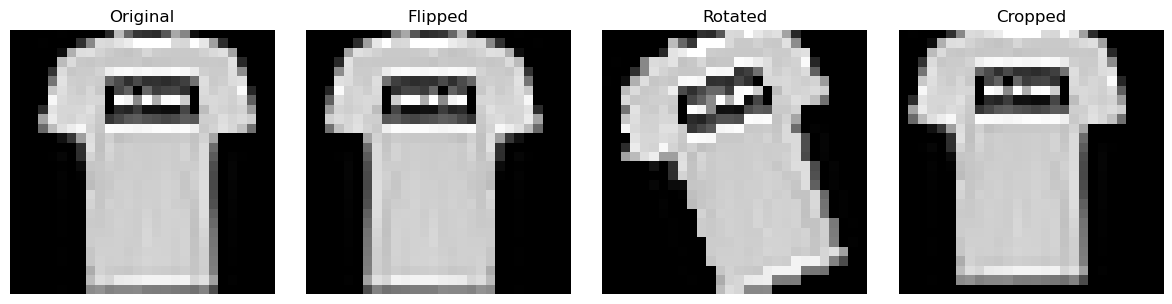

In [ ]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

dataset = datasets.FashionMNIST(root='./data', train=True, download=True)

# Вывод изображения для демонстрации
image, _ = dataset[1]

# Определение аугментации
transform_flip = transforms.RandomHorizontalFlip(p=1)  # force flip every time
transform_rotate = transforms.RandomRotation(20)
transform_crop = transforms.RandomCrop(28, padding=4)

# Применение аугментации
image_flip = transform_flip(image)
image_rotate = transform_rotate(image)
image_crop = transform_crop(image)

# Визуализация
fig, axs = plt.subplots(1, 4, figsize=(12, 3))

axs[0].imshow(image, cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')

axs[1].imshow(image_flip, cmap='gray')
axs[1].set_title('Flipped')
axs[1].axis('off')

axs[2].imshow(image_rotate, cmap='gray')
axs[2].set_title('Rotated')
axs[2].axis('off')

axs[3].imshow(image_crop, cmap='gray')
axs[3].set_title('Cropped')
axs[3].axis('off')

plt.tight_layout()
plt.show()